In [2]:
import jax
import jax.numpy as jnp  # JAX NumPy
from jax.scipy.special import logsumexp
import sys
print(sys.path)

from flowMC.nfmodel.realNVP import RealNVP
from flowMC.sampler.MALA import mala_sampler
from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys
from flowMC.nfmodel.utils import *

['/home/kaze/Work/NFSampler/example/notebook', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/kaze/Environment/NFSampler/lib/python3.9/site-packages']


In [3]:

def dual_moon_pe(x):
    """
    Term 2 and 3 separate the distribution and smear it along the first and second dimension
    """
    term1 = 0.5 * ((jnp.linalg.norm(x) - 2) / 0.1) ** 2
    term2 = -0.5 * ((x[:1] + jnp.array([-3.0, 3.0])) / 0.8) ** 2
    term3 = -0.5 * ((x[1:2] + jnp.array([-3.0, 3.0])) / 0.6) ** 2
    return -(term1 - logsumexp(term2) - logsumexp(term3))


d_dual_moon = jax.grad(dual_moon_pe)


In [4]:
### Demo config

n_dim = 5
n_chains = 10
n_loop = 5
n_local_steps = 100
n_global_steps = 100
learning_rate = 0.1
momentum = 0.9
num_epochs = 5
batch_size = 50
stepsize = 0.01

print("Preparing RNG keys")
rng_key_set = initialize_rng_keys(n_chains, seed=42)

print("Initializing MCMC model and normalizing flow model.")

initial_position = jax.random.normal(rng_key_set[0], shape=(n_chains, n_dim)) * 1


model = RealNVP(10, n_dim, 64, 1)
run_mcmc = jax.vmap(mala_sampler, in_axes=(0, None, None, None, 0, None), out_axes=0)






Preparing RNG keys
Initializing MCMC model and normalizing flow model.


In [5]:
print("Initializing sampler class")

nf_sampler = Sampler(n_dim, rng_key_set, model, run_mcmc,
                    dual_moon_pe,
                    d_likelihood=d_dual_moon,
                    n_loop=n_loop,
                    n_local_steps=n_local_steps,
                    n_global_steps=n_global_steps,
                    n_chains=n_chains,
                    n_epochs=num_epochs,
                    n_nf_samples=100,
                    learning_rate=learning_rate,
                    momentum=momentum,
                    batch_size=batch_size,
                    stepsize=stepsize,
                    use_global=True,)

print("Sampling")

nf_sampler.sample(initial_position)

chains, log_prob, local_accs, global_accs, loss_vals = nf_sampler.get_sampler_state()
nf_samples = nf_sampler.sample_flow()

print(
    "chains shape: ",
    chains.shape,
    "local_accs shape: ",
    local_accs.shape,
    "global_accs shape: ",
    global_accs.shape,
)

chains = jnp.array(chains)
nf_samples = jnp.array(nf_samples[1])
loss_vals = jnp.array(loss_vals)


Initializing sampler class
Sampling
chains shape:  (10, 1000, 5) local_accs shape:  (10, 500) global_accs shape:  (10, 500)


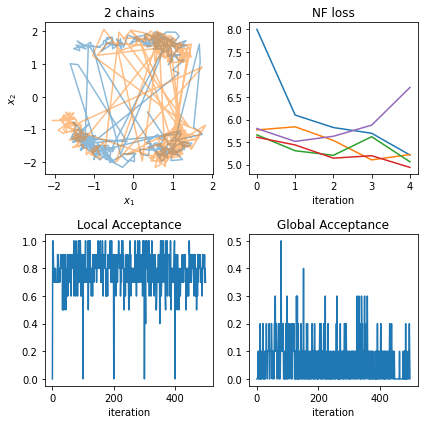

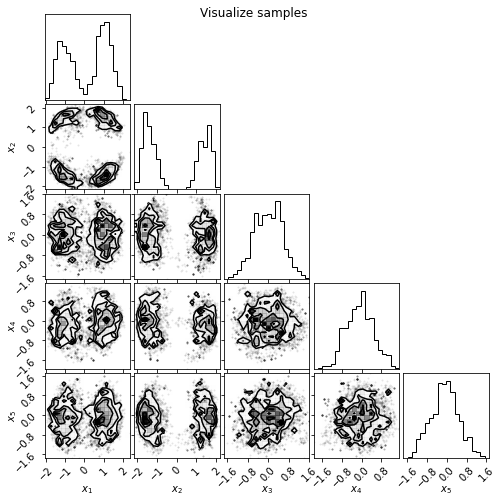

ValueError: Can only convert xarray dataarray, xarray dataset, dict, netcdf filename, numpy array, pystan fit, pymc3 trace, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not DeviceArray

In [7]:
import corner
import matplotlib.pyplot as plt
import numpy as np

chains = np.array(chains)

# Plot one chain to show the jump
plt.figure(figsize=(6, 6))
axs = [plt.subplot(2, 2, i + 1) for i in range(4)]
plt.sca(axs[0])
plt.title("2 chains")
plt.plot(chains[0, :, 0], chains[0, :, 1], alpha=0.5)
plt.plot(chains[1, :, 0], chains[1, :, 1], alpha=0.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.sca(axs[1])
plt.title("NF loss")
plt.plot(loss_vals)
plt.xlabel("iteration")

plt.sca(axs[2])
plt.title("Local Acceptance")
plt.plot(local_accs.mean(0))
plt.xlabel("iteration")

plt.sca(axs[3])
plt.title("Global Acceptance")
plt.plot(global_accs.mean(0))
plt.xlabel("iteration")
plt.tight_layout()
plt.show(block=False)

# Plot all chains
figure = corner.corner(
    chains.reshape(-1, n_dim), labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"]
)
figure.set_size_inches(7, 7)
figure.suptitle("Visualize samples")
plt.show(block=False)

# Plot Nf samples
figure = corner.corner(nf_samples, labels=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"])
figure.set_size_inches(7, 7)
figure.suptitle("Visualize NF samples")
plt.show(block=False)